In [ ]:
cimport numpy as np
import pandas as pd
from datetime import datetime


tickers = [
    "RELIANCE", "TCS", "INFY", "HDFCBANK", "ICICIBANK",
    "SBIN", "BHARTIARTL", "ITC", "LT", "AXISBANK"
]


date_range = pd.date_range(start="2018-01-01", end=datetime.today(), freq='B')


def generate_stock_data(ticker, dates):
    np.random.seed(hash(ticker) % 2**32)
    n = len(dates)
    base_price = np.random.uniform(200, 3000)


    returns = np.random.normal(0, 0.01, n)
    close_prices = base_price * np.cumprod(1 + returns)


    open_prices = close_prices * np.random.uniform(0.98, 1.02, n)
    high_prices = np.maximum(open_prices, close_prices) * np.random.uniform(1.00, 1.03, n)
    low_prices = np.minimum(open_prices, close_prices) * np.random.uniform(0.97, 1.00, n)
    volume = np.random.randint(100000, 10000000, n)

    return pd.DataFrame({
        "Date": dates,
        "Open": open_prices,
        "High": high_prices,
        "Low": low_prices,
        "Close": close_prices,
        "Volume": volume,
        "Ticker": ticker
    })


df_list = [generate_stock_data(ticker, date_range) for ticker in tickers]
stock_data = pd.concat(df_list, ignore_index=True)


stock_data.to_csv("mock_indian_stocks_dataset.csv", index=False)
print("✅ Mock stock dataset saved as 'mock_indian_stocks_dataset.csv'")

✅ Mock stock dataset saved as 'mock_indian_stocks_dataset.csv'


Available tickers: RELIANCE, TCS, INFY, HDFCBANK, ICICIBANK, SBIN, BHARTIARTL, ITC, LT, AXISBANK
Enter the stock ticker you want to predict (e.g., RELIANCE): RELIANCE
📉 Model MAE: 80.55


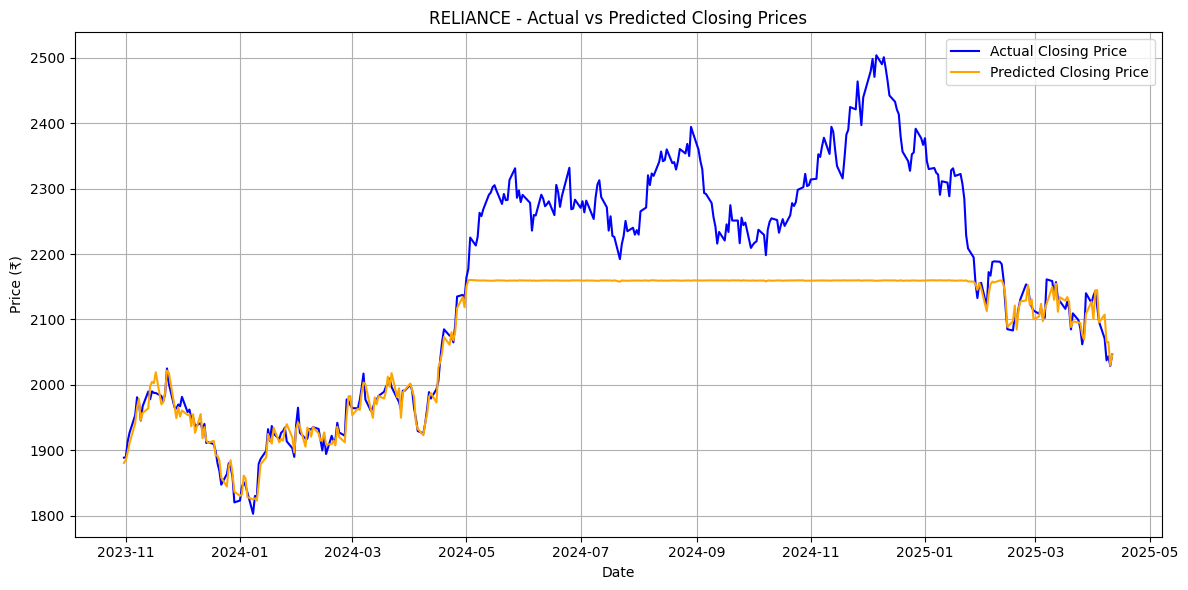


📆 Last Date in Data: 2025-04-11
📈 Predicted next day's closing price for RELIANCE: ₹2051.32


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import datetime
import matplotlib.pyplot as plt


df = pd.read_csv("mock_indian_stocks_dataset.csv")


df['Date'] = pd.to_datetime(df['Date'])


available_tickers = df['Ticker'].unique()
print("Available tickers:", ', '.join(available_tickers))
user_ticker = input("Enter the stock ticker you want to predict (e.g., RELIANCE): ").upper()

if user_ticker not in available_tickers:
    print("❌ Invalid ticker! Please run the program again.")
    exit()


data = df[df['Ticker'] == user_ticker].copy()


data.sort_values("Date", inplace=True)


data["Prev_Close"] = data["Close"].shift(1)
data["MA_5"] = data["Close"].rolling(5).mean()
data["MA_10"] = data["Close"].rolling(10).mean()


data.dropna(inplace=True)


X = data[["Open", "High", "Low", "Volume", "Prev_Close", "MA_5", "MA_10"]]
y = data["Close"]


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"📉 Model MAE: {mae:.2f}")


last_row = data.iloc[-1]
next_input = pd.DataFrame([{
    "Open": last_row["Open"],
    "High": last_row["High"],
    "Low": last_row["Low"],
    "Volume": last_row["Volume"],
    "Prev_Close": last_row["Close"],
    "MA_5": data["Close"].iloc[-5:].mean(),
    "MA_10": data["Close"].iloc[-10:].mean()
}])

next_prediction = model.predict(next_input)[0]





plt.figure(figsize=(12, 6))
plt.plot(data['Date'].iloc[-len(y_test):], y_test, label="Actual Closing Price", color='blue')
plt.plot(data['Date'].iloc[-len(y_test):], preds, label="Predicted Closing Price", color='orange')
plt.title(f"{user_ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"\n📆 Last Date in Data: {data['Date'].iloc[-1].date()}")
print(f"📈 Predicted next day's closing price for {user_ticker}: ₹{next_prediction:.2f}")